In [109]:
import sys, os
sys.path.append(os.getcwd()+"/../")

import numpy as np
import matplotlib.pyplot as plt
from math import isclose
from sklearn.preprocessing import StandardScaler
from skesn.esn import EsnForecaster, ACTIVATIONS, update_modes
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks
from skesn.weight_generators import optimal_weights_generator

In [57]:
def _lorenz(x_0, dt, t_final, rho_ = 28.):
    sigma_ = 10.
    beta_ = 8./3.

    def rhs(x):
        f_ = np.zeros(3)
        f_[0] = sigma_ * (x[1] - x[0])
        f_[1] = rho_ * x[0] - x[0] * x[2] - x[1]
        f_[2] = x[0] * x[1] - beta_ * x[2]
        return f_

    times = np.arange(0, t_final, dt)
    ts = np.zeros((len(times), 3))
    ts[0, :] = x_0
    cur_x = x_0
    dt_integr = 10**(-3)
    n_timesteps = int(np.ceil(dt / dt_integr))
    dt_integr = dt / n_timesteps
    for i in range(1, n_timesteps*len(times)):
        cur_x = cur_x + dt_integr * rhs(cur_x)
        saved_time_i = i*dt_integr / dt
        if isclose(saved_time_i, np.round(saved_time_i)):
            saved_time_i = int(np.round(i*dt_integr / dt))
            ts[saved_time_i, :] = cur_x
    return ts, times

In [67]:
np.random.seed(0)

data_28, time_28 = _lorenz(np.random.rand(3,), 2e-3, 200, 28)
data_32, time_32 = _lorenz(np.random.rand(3,), 2e-3, 200, 32)

data_28 = data_28[10000::10]
data_32 = data_32[10000::10]
time_28 = time_28[:-10000:10]
time_32 = time_32[:-10000:10]

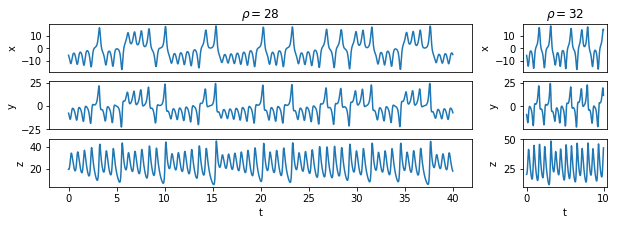

In [85]:
fig, axs = plt.subplots(3, 2, figsize=(10,3), gridspec_kw={'width_ratios': [5, 1]})
for i in range(6):
    ax = axs[i // 2, i % 2]
    ax.plot([time_28[:2000], time_32[:500]][i % 2], 
            [data_28[:2000], data_32[:500]][i % 2][:, i // 2])
    if(i // 2 < 2): ax.set_xticks([])
    else: ax.set_xlabel("t")
    ax.set_ylabel(["x","y","z"][i // 2]) 
    if(i // 2 == 0):
        ax.set_title(r"$\rho = %d$" % ([28, 32][i % 2]))

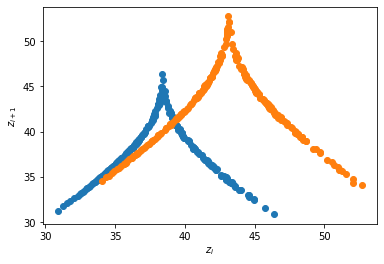

In [89]:
peaks_28, _ = find_peaks(data_28[:, 2], height=0)
peaks_28 = data_28[peaks_28, 2]
peaks_32, _ = find_peaks(data_32[:, 2], height=0)
peaks_32 = data_32[peaks_32, 2]
plt.scatter(peaks_28[:-1], peaks_28[1:])
plt.scatter(peaks_32[:-1], peaks_32[1:])
plt.xlabel("$z_i$")
plt.ylabel("$z_{i+1}$")
None

In [92]:
scaler = StandardScaler()
data_28_train = scaler.fit_transform(data_28[:2000])
data_32_train = scaler.transform(data_32[:500])

In [93]:
model = EsnForecaster(
    n_reservoir=300,
    spectral_radius=0.99,
    sparsity=0.9,
    regularization='l2',
    lambda_r=1e-4,
    in_activation='tanh',
    random_state=0,
)


------------Reservoir searching------------
Hidden matrix generation...


100%|█████████▉| 499/500 [00:23<00:00, 21.14it/s]]


Optimal scale: 0.019866
-------------------------------------------

fitting...


100%|█████████▉| 1999/2000 [00:00<00:00, 7514.61it/s]


solving...


EsnForecaster(lambda_r=0.0001, n_reservoir=300, random_state=0,
              regularization='l2', sparsity=0.9, spectral_radius=0.99,
              use_additive_noise_when_forecasting=False)

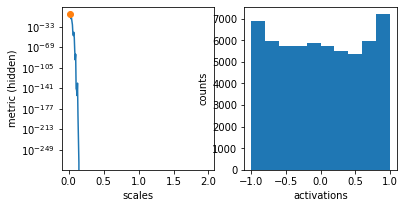

In [99]:
model.fit(data_28_train, inspect = True, initialization_strategy = optimal_weights_generator(
    verbose = 2,
    range_generator=np.linspace,
    steps = 300,
    hidden_std = 0.5,
    find_optimal_input = False,
    thinning_step = 10,
))
# plt.savefig("ESNoptimal_hidden_search.png", bbox_inches="tight", dpi=300)

In [106]:
prediction_28 = scaler.inverse_transform(model.predict(8000))

In [110]:
model.update(data_32_train, mode = update_modes.transfer_learning)

EsnForecaster(lambda_r=0.0001, n_reservoir=300, random_state=0,
              regularization='l2', sparsity=0.9, spectral_radius=0.99,
              use_additive_noise_when_forecasting=False)

In [111]:
prediction_32 = scaler.inverse_transform(model.predict(8000))

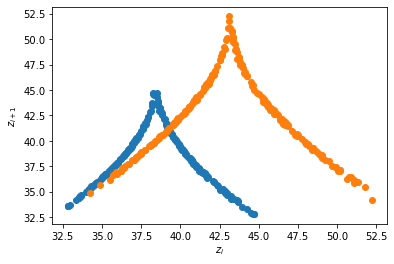

In [113]:
peaks_28, _ = find_peaks(prediction_28[:, 2], height=0)
peaks_28 = prediction_28[peaks_28, 2]
peaks_32, _ = find_peaks(prediction_32[:, 2], height=0)
peaks_32 = prediction_32[peaks_32, 2]
plt.scatter(peaks_28[:-1], peaks_28[1:])
plt.scatter(peaks_32[:-1], peaks_32[1:])
plt.xlabel("$z_i$")
plt.ylabel("$z_{i+1}$")
None